# Reconstruction parcimonieuse ou compressive sensing

## I. Cadre général et première tentative.

Le but du TP est de montrer que des techniques d'optimisation pour le Machine Learning permettent de récupérer des signaux qui admettent dans une certaine base une représentation parcimonieuse, c'est à dire mettant en jeu un faible nombre de coefficients. 

On s'intéresse donc à la reconstruction d'un vecteur $x$ (ici une image codées en niveaux de gris) en utilisant les valeurs de combinaisons aléatoire de certains pixels. Les combinaisons sont représentées par une matrice $\Phi$. 

Une première approche consiste à résoudre le problème $$ \min_x \frac{1}{2} ||\Phi x-y||_2^2$$ pour retrouver l'image.

**Question 1 :** Commenter et compléter le code constituant le reste de la section I.


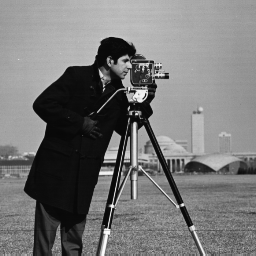

In [4]:
#
# Installation des librairies
#
#Pkg.add("")
#
#

#
# Repertoire ou se trouve le fichier cameraman.tif
#
#cd("$(homedir())/") 

#
# Chargement des librairies de traitement d'image
#
using Images, Colors, LinearAlgebra, FFTW


img1 = load("cameraman.tif");    # 
A=convert(Array{Gray},img1);   # 
#A = float(convert(Array,img));  # 

tmp=@view img1[:,:]

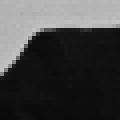

In [121]:
# Extraction d'une sous-image contrastée
k    = 30;
orig = 60;
Aloc   = A[orig:orig+k-1,orig:orig+k-1];
x   = (Aloc[:]);
n   = length(x);
m   = 500; 
Phi = randn(m,n);

#imhsv=colorview(Gray,float(Aloc));     #MODIF : ne fonctionne plus

#tmp=@view imhsv[:,:]   #MODIF : ne fonctionne plus
tmp=@view Aloc[:,:]

#
# Fin Extraction
#


**Question 2 :** Résoudre le problème de moindres carrés $$\min_x || \Phi x -y ||_2,$$ et afficher le résultat (attention, l'image doit être en niveaux de gris). Que constate-t-on?

<!-- Ajout de moi -->

On va résoudre le problème aux moindres carrés linéaires suivant :
$$\min_{x \in \mathbb{R}^n} \cfrac{1}{2}|| \Phi x - y ||_2^2,$$

On sait qu'une solution de ce problème est :
$$\tilde{x} = \Phi^{+}y \text{ avec } \Phi^{+} = \Phi^{T}(\Phi\Phi^{T})^{-1} \text{ pseudo-inverse de } \Phi $$

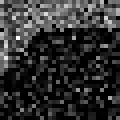

In [122]:
y = Phi*x ; # Vecteur des "observations" de l'image
y = convert.(Float64,y)     #AJOUT
## A compléter
Phi_pseudo_inverse = pinv(Phi)
x_tilde = Phi_pseudo_inverse*y       #pinv pour avoir la pseudo-inverse
x_tilde = reshape(x_tilde,k,k)
x_tilde = convert(Array{Gray},x_tilde)
## Fin à compléter

#### II. Compressive sensing


On désire utiliser à présent la transformation discrète en cosinus pour obtenir une représentaiton parcimonieuse d'une image. Cette transfomation bijective est obtenue avec la fonction `dct`, son inverse s'appelant `idct`.

A partir de la fonction IDCT de Julia, on calcule la matrice  $\Theta = \Phi*\Psi$, avec $\Psi$ la matrice représentative de IDCT dans la base canonique.


In [123]:
Theta = zeros(m,n);
for ii = 1:n
    ii
    ek = zeros(1,n);
    ek[ii] = 1;
    psi = idct(ek)';
    Theta[:,ii] = Phi*psi;
end

### II.1. Utilisation d'un algorithme de sous-gradient

**Question 3 :** Soit $\lambda > 0$ (ici $\lambda=100$). Expliquer l'intérêt de 
 calculer $x_{sg}= \Psi z$ où $z$ résout $$\min_z \frac{1}{2} ||\Phi  \cdot \Psi  \cdot z -y||_2^2+ \lambda ||z||_1.$$ 

La norme 1 favorise la représentation parcimonieuse de signaux. Or, pour notre signal, cela n'est pas forcément le cas dans la base canonique. Nous allons donc faire un changement de base pour que notre représentation soit plus parcimonieuse (beaucoup de coefficient nuls dans la nouvelle base).

On fait donc le changement de variable $x_{sg}= \Psi z$.

**Question 4 :** Justifier la convexité de la fonctionnelle et donner son sous-différentiel.

La fonction $u : z \longmapsto \Phi \cdot \Psi \cdot z$ est une application linéaire (donc convexe) et les normes sont convexes (par inégalité triangulaire). Ainsi, par composition et combinaison linéaire à coefficients positifs, la fonctionnelle $f : z \longmapsto \frac{1}{2} ||\Phi  \cdot \Psi  \cdot z -y||_2^2+ \lambda ||z||_1$ est convexe.



Dans le TP, on a déjà déterminer le sous-différentiel de la fonctionnelle au point $z$ :
$$g = \Theta^{T}(\Theta z - y) + \lambda \cdot \text{sign}(z)$$

**Question 5 :** Compléter ci-dessous le code de sous-gradient projeté. Vous considèrerez les différents choix de pas $\alpha_i$ vus en cours, et trouverez des réglages permettant d'obtenir un bon rendu visuel. On pourra se rappeler du fait que la solution de norme minimale a une norme inférieure à dix.

In [124]:
z = zeros(k^2,1); i=0; lambda=1e-2;
choix_pas = 2; # 1 cas a, 2 cas b, 3 cas c


function eval_grad(z)
    return (transpose(Theta)*(Theta*z - y) + lambda * sign.(z))
end



while i <= 1000
    i = i + 1; 
    ## A compléter
    g = eval_grad(z)
    

    if choix_pas == 1
        alpha = 1 / i;
    
    elseif choix_pas == 2
        alpha = 10^(-2) / (i^2);

    else
        alpha = 1
    end
    
    z = z - alpha*g
    ## fin à compléter
end
norm(Theta\y)

8.915077996944989

**Question 6 :** Expliquer le code suivant et conclure sur l'utilisation du sous-gradient

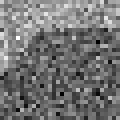

In [125]:
function my_function(n,k,z)
    x2 = zeros(n,1);
    for ii = 1:n
        ii
        ek = zeros(1,n);
        ek[ii] = 1;
        psi = idct(ek)';
        x2 = x2+psi*z[ii];
    end
    x2 = reshape(x2,k,k);
    x2 = 1/(maximum(x2).-minimum(x2))*(x2.-minimum(x2));
    return x2
end
#
x2 = my_function(n,k,z);
imhsv = colorview(Gray, float(x2));
tmp=@view imhsv[:,:]

# II.2. Utilisation d'un algorithme de sous-gradient projeté


**Question 7 :**  Expliquer l'intérêt de 
 calculer $x_{sgp}= \Psi z$ où $z$ résout $$\min_{\Phi  \cdot \Psi  \cdot z =y}  ||z||_1.$$

Même réponse que précédemment.

**Question 8 :** Rappeler la formule de la projection sur le convexe $\{x, \Phi  \cdot \Psi  \cdot z =y \}$ vue en cours.

En posant $\Theta = \Phi  \cdot \Psi$, la projection sur le convexe $\mathcal{C} = \{x, \Phi  \cdot \Psi  \cdot z =y \}$ a pour formule :

$$\Pi_\mathcal{C}(z) = z - \Theta^{T}(\Theta\Theta^{T})^{-1}(\Theta z - y) = z - \Theta^{+}(\Theta z - y)$$

**Question 9 :** Résoudre ce problème par l'algorithme de sous-gradient projeté et finaliser le calcul de la solution.

In [143]:
z = zeros(k^2,1); 
i=0;
choix_pas = 1; # 1 cas a, 2 cas b, 3 cas c

##Initialisation (possible)
## A compléter
Theta_pseudo_inverse = transpose(Theta)*inv(Theta*transpose(Theta))     # a priori on aurait pu mettre pinv(Theta)
## Fin à compléter

z = z - Theta_pseudo_inverse*(Theta*z - y)

function eval_grad_projete(z)
    return sign.(z)
end

B = I - Theta_pseudo_inverse * Theta

while i <= 1000
    i = i + 1; 
    ## A compléter

    if choix_pas == 1
        alpha = 1 / i;
    
    elseif choix_pas == 2
        alpha = 10^(-2) / (i^2);

    else
        alpha = 1
    end

    z = z - alpha*B*sign.(z)

    ## Fin à compléter
end

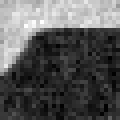

In [144]:
x3 = my_function(n,k,z);
imhsv = colorview(Gray,float(x3));
tmp =@view imhsv[:,:]